## **Personalities (WIP Title)**
### A better way to get big five personalities

Data source:
https://www.kaggle.com/tunguz/big-five-personality-test

### **Data Preprocessing**

In [114]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fp = "data/data-final.csv"
# load data
data = pd.read_csv(fp, sep="\t", usecols=range(50))
# drop na rows
data.dropna(inplace=True)
# drop rows with more than 2 skipped questions
answr_0_cts = (data==0.0).apply(sum, axis=1)
data = data[answr_0_cts<=2]

In [3]:
data = data.astype(int)

In [4]:
data.shape

(1003839, 40)

In [11]:
data[data==0] = np.NaN

In [13]:
# Impute the skipped questions
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
data_filled = imputer.fit_transform(data)

In [35]:
data_filled = pd.DataFrame(data_filled).apply(round)
mapping = {1.0: -0.9, 2.0: -0.4, 3.0: -0.1, 4.0: 0.4, 5.0:0.9}
data_new = np.zeros(data_filled.shape)
for r in range(data_new.shape[0]):
    for c in range(data_new.shape[1]):
        data_new[r,c] = mapping[data_filled.iloc[r,c]]

In [ ]:
pd.DataFrame(data_new, columns = data.columns).to_csv("data/data_preproc_knn.csv", index=False)

In [20]:
def load_data(fp, test_prop):
    """
    loads and transforms data for modeling
    takes a fp to a csv file
    returns a pandas dataframe
    """

    # load data
    data = pd.read_csv(fp)
    # # drop na rows
    # data.dropna(inplace=True)
    # # drop rows with more than 2 skipped questions
    # answr_0_cts = (data == 0.0).apply(sum, axis=1)
    # data = data[answr_0_cts <= 2]

    # split train and test
    # how many rows to sample
    n_samps = int(data.shape[0] * (1 - test_prop))
    # sample from row indices
    train_idx = random.sample(range(data.shape[0]), n_samps)
    test_idx = list(set(range(data.shape[0])) - set(train_idx))

    return data.loc[train_idx,:], data.loc[test_idx,:]

In [21]:
def load_data(fp, test_prop):
    """
    loads and transforms data for modeling
    takes a fp to a csv file
    returns a pandas dataframe
    """

    # load data
    data = pd.read_csv(fp)
    # # drop na rows
    # data.dropna(inplace=True)
    # # drop rows with more than 2 skipped questions
    # answr_0_cts = (data == 0.0).apply(sum, axis=1)
    # data = data[answr_0_cts <= 2]

    # split train and test
    # how many rows to sample
    n_samps = int(data.shape[0] * (1 - test_prop))
    # sample from row indices
    train_idx = random.sample(range(data.shape[0]), n_samps)
    test_idx = list(set(range(data.shape[0])) - set(train_idx))

    return data.loc[train_idx,:], data.loc[test_idx,:]

## **Modeling**

The basic assumption is that the data is generated from a process that ultimately leads to a number of independent latent variables, which we might call personality types. The number of these variables is determined arbitrarily and can be a hyperparameter to tune. We also assume that these latent variables follow a beta distribution with parameters alpha and beta, which are determined through a deep neural network. Overall, we will use variational autoencoder structure to learn the weights to the neural network, which are optimized to reproduce the answers observed in the data.

The use of beta distribution is due to it being able to output a bounded number between 0 and 1, which is useful and interpretable as a measurement of personality traits. Using this distribution we can also output a confidence interval for each personality measurements.

The actual model training is done in a separate script. Here we will try to figure out a way to interpret the latent vector by disabling one dimension at a time and see if it works.

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Layer, Concatenate, Lambda, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

/home/roblee/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/roblee/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/roblee/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/roblee/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [46]:
# load the model and see if we can extract the weights

def reconstruct_ae(input_dim, layer_dim, encoder_dim, dropout_rate, wgt_fp, load_wgts = True):

    # Encoder
    input_encoder = Input(shape=(input_dim, ))
    encoder1 = Dense(layer_dim, activation="tanh")(input_encoder)
    e_bnorm1 = BatchNormalization(axis=1)(encoder1)
    e_dropout1 = Dropout(dropout_rate)(e_bnorm1)
    encoder2 = Dense(layer_dim, activation="tanh")(e_dropout1)
    e_bnorm2 = BatchNormalization(axis=1)(encoder2)
    e_dropout2 = Dropout(dropout_rate)(e_bnorm2)

    # output of encoder
    input_o_encoder = Input(shape=(layer_dim, ))
    output_encoder = Dense(encoder_dim, activation="sigmoid")(input_o_encoder)

    # Decoder
    input_decoder = Input(shape=(encoder_dim, ))
    decoder1 = Dense(layer_dim, activation='tanh')(input_decoder)
    d_bnorm1 = BatchNormalization(axis=1)(decoder1)
    d_dropout1 = Dropout(dropout_rate)(d_bnorm1)
    decoder2 = Dense(layer_dim, activation='tanh')(d_dropout1)
    d_bnorm2 = BatchNormalization(axis=1)(decoder2)
    d_dropout2 = Dropout(dropout_rate)(d_bnorm2)
    output_decoder = Dense(input_dim, activation='tanh')(d_dropout2)

    encoder_latent = Model(inputs=input_encoder, outputs=e_dropout2, name='encoder')
    encoder_out = Model(inputs=input_o_encoder, outputs=output_encoder)
    encoder = Model(inputs=input_encoder, outputs=encoder_out(encoder_latent(input_encoder)))
    decoder = Model(inputs=input_decoder, outputs=output_decoder, name='decoder')
    autoencoder = Model(inputs=input_encoder, outputs=decoder(encoder(input_encoder)), name='ae')
    
    if load_wgts:
        autoencoder.load_weights(wgt_fp)

    return autoencoder

In [47]:
input_dim = 40
layer_dim = 512
encoder_dim = 5
dropout_rate = 0.1
learning_rate = 0.01
wgt_fp = "models/ae_model.h5"

ae_model = reconstruct_ae(input_dim, layer_dim, encoder_dim, dropout_rate, wgt_fp)

In [91]:
ae_model.layers[2].layers

In [40]:
# These are the layers to change
for array in ae_model.layers[1].layers[-1].get_weights():
    print(array.shape)

(512, 5)
(5,)


In [41]:
for array in ae_model.layers[2].layers[1].get_weights():
    print(array.shape)

(5, 512)
(512,)


In [95]:
i = 0
latent_dim = 5
n_questions = 40

# get rid of ith column
selected_cols = list(set(range(latent_dim)) - set([i]))
# reconstruct model with one less num of dim in encoder output
ae_model_recon = reconstruct_ae(n_questions, layer_dim, latent_dim-1, dropout_rate, wgt_fp, False)
# set the weights manually
ae_model_recon.layers[1].layers[1].set_weights(ae_model.layers[1].layers[1].get_weights())
# modify weight dim for the last layer of encoder
wghts_mod_1 = []
wghts_mod_1.append(ae_model.layers[1].layers[2].get_weights()[0][:,selected_cols])
wghts_mod_1.append(ae_model.layers[1].layers[2].get_weights()[1][selected_cols])
ae_model_recon.layers[1].layers[2].set_weights(wghts_mod_1)
# modify weights again for the first layer of decoder
wghts_mod_2 = []
wghts_mod_2.append(ae_model.layers[2].layers[1].get_weights()[0][selected_cols,:])
wghts_mod_2.append(ae_model.layers[2].layers[1].get_weights()[1])
ae_model_recon.layers[2].layers[1].set_weights(wghts_mod_2)
# set weights manually for layers 2-7 in decoder
for lyr in range(2,8):
    ae_model_recon.layers[2].layers[lyr].set_weights(ae_model.layers[2].layers[lyr].get_weights())

In [105]:
pred = ae_model.predict(data.values)

In [106]:
pred_recon = ae_model_recon.predict(data.values)

In [107]:
# calculate total per question loss
np.square(pred - pred_recon).sum(axis=0)

array([ 66110.73  ,  22127.541 ,  13234.835 ,   8113.573 ,  10177.406 ,
        13310.528 ,  40889.59  ,  11140.362 ,  11582.636 ,  13250.015 ,
       677208.7   , 373501.78  , 554460.2   , 195799.77  , 284536.3   ,
       503027.1   , 444613.25  , 426591.4   , 530367.2   , 316285.5   ,
        50517.574 ,  16572.053 ,  48609.668 ,  42257.812 ,   6916.1416,
       123121.28  ,   6464.966 ,   5362.3423,  87446.18  ,   4849.947 ,
         8313.95  ,  11114.813 ,   8286.5625,  58937.367 ,  11884.769 ,
        16600.682 ,  51544.297 ,  14317.079 , 102005.664 ,  12577.176 ],
      dtype=float32)

In [110]:
def interpret_latent_layer(data, ae_model):
    """
    returns reconstruction loss for each question if one of latent dim is taken out
    """
    latent_dim = 5
    n_questions = 40 
    output = np.zeros((latent_dim, n_questions))
    
    pred = ae_model.predict(data.values)
    
    for i in range(latent_dim):
        # get rid of ith column
        selected_cols = list(set(range(latent_dim)) - set([i]))
        # reconstruct model with one less num of dim in encoder output
        ae_model_recon = reconstruct_ae(n_questions, layer_dim, latent_dim-1, dropout_rate, wgt_fp, False)
        # set the weights manually
        ae_model_recon.layers[1].layers[1].set_weights(ae_model.layers[1].layers[1].get_weights())
        # modify weight dim for the last layer of encoder
        wghts_mod_1 = []
        wghts_mod_1.append(ae_model.layers[1].layers[2].get_weights()[0][:,selected_cols])
        wghts_mod_1.append(ae_model.layers[1].layers[2].get_weights()[1][selected_cols])
        ae_model_recon.layers[1].layers[2].set_weights(wghts_mod_1)
        # modify weights again for the first layer of decoder
        wghts_mod_2 = []
        wghts_mod_2.append(ae_model.layers[2].layers[1].get_weights()[0][selected_cols,:])
        wghts_mod_2.append(ae_model.layers[2].layers[1].get_weights()[1])
        ae_model_recon.layers[2].layers[1].set_weights(wghts_mod_2)
        # set weights manually for layers 2-7 in decoder
        for lyr in range(2,8):
            ae_model_recon.layers[2].layers[lyr].set_weights(ae_model.layers[2].layers[lyr].get_weights())
        
        # calculate total squared error loss for each question
        pred_recon = ae_model_recon.predict(data.values)
        output[i] = np.square(pred - pred_recon).sum(axis=0)
    
    return output

In [111]:
answer_loss = interpret_latent_layer(data, ae_model)

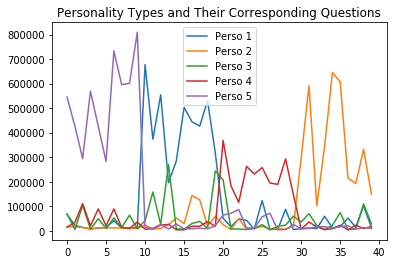

In [128]:
# let's plot this as line graph
for i in range(5):
    plt.plot(answer_loss[i], label="Perso %i" % (i+1))
plt.legend()
plt.title("Personality Types and Their Corresponding Questions")
plt.savefig("perso_types.png")

In [22]:
for array in decoder_model.layers[0].get_weights():
    print(array.shape)

In [12]:
# reconstruct model

input_o_encoder = Input(shape=(layer_dim, ))
output_encoder = Dense(encoder_dim, activation="sigmoid")(input_o_encoder)
encoder_out = Model(inputs=input_o_encoder, outputs=output_encoder)

# Get weights from trained model
encoder_out.load_weights("models/encoder_out_model.h5")
weights = encoder_out.layers[1].get_weights()

In [13]:
weights

[array([[-0.03761424, -0.00707147,  0.00090427, -0.01330018, -0.00627301],
        [ 0.218801  , -0.07438095,  0.33807376, -0.00495258,  0.3611041 ],
        [ 0.00487093,  0.00308015,  0.00207358,  0.00261693,  0.00903295],
        ...,
        [ 0.13145614,  0.21304595, -0.4560745 , -0.31178954,  0.00292756],
        [-0.20002744, -0.03073133, -0.34470347,  0.15862438, -0.0436524 ],
        [-0.07714497, -0.05257611,  0.10625625, -0.09523363,  0.00128756]],
       dtype=float32),
 array([-0.9283109 , -1.280707  , -1.5039036 , -1.7589775 , -0.84670234],
       dtype=float32)]

In [14]:
# load data
data = pd.read_csv("data/data_preproc_knn.csv")